In [19]:
from cloudvolume import CloudVolume, view
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


For now, I'll only look at a tiny region of entire dataset. So we need to think about how to scale up this approach later.

In [3]:
image = image_cv.download_point( (52785, 86885, 1894), mip=4, size=(128, 128, 256) ) # mip2+ only
# mip needs to be the same?
# 4.3*2^4*128/45=196
# 30s

In [2]:
image_cv = CloudVolume(
    'precomputed://gs://lee-lab_female-adult-nerve-cord_tokyo-storage/alignmentV4/em/rechunked',
    progress=False,
    cache=True, # cache to disk to avoid repeated downloads
    use_https=True
)

nuclei_cv = CloudVolume(
    'precomputed://gs://ranl_scratch_zetta_30/neuroglancer/nuclei/3d528bc3def9f51e09ae55e68ee46518',
    progress=True,
    cache=True, # cache to disk to avoid repeated downloads
    use_https=True
)

In [3]:
image = image_cv.download_point( (52785, 86885, 1894), mip=4, size=(128, 128, 256) ) # mip2+ only
# mip needs to be the same?
# 4.3*2^4*128/45=196
# 30s

In [4]:
nuclei = nuclei_cv.download_point( (52785, 86885, 1894), mip=[68.8,68.8,45.0], size=(128, 128, 256) ) # mip 0 or 4 only
# 10min!?

Downloading: 100%|██████████| 162/162 [00:02<00:00,  5.30it/s]

In [5]:
# view(image)

Viewer server listening to http://localhost:8080


127.0.0.1 - - [08/Jul/2021 04:07:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:07:19] "GET /datacube.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:07:19] "GET /jquery-3.3.1.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:07:20] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:07:21] "GET /channel HTTP/1.1" 200 -



Continuing program execution...


In [7]:
# view(nuclei)

Viewer server listening to http://localhost:8080


127.0.0.1 - - [08/Jul/2021 04:19:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:19:25] "GET /jquery-3.3.1.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:19:25] "GET /datacube.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:19:26] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:19:27] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [08/Jul/2021 04:19:27] "GET /channel HTTP/1.1" 200 -



Continuing program execution...


In [13]:
test = image[:,:,:]
testn = nuclei[:,:,:]
type(test)
type(testn)

cloudvolume.volumecutout.VolumeCutout

In [16]:
np.where(testn > 0.5, 1, 0)

array([[[[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [1],
         [1]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


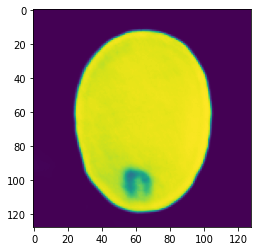

In [21]:
# view(testn)
plt.imshow(testn[:,:,149])


In [6]:
image_cv.cache.flush()
nuclei_cv.cache.flush() 

In [ ]:
xmax-xmin
ymax-ymin
zmax-zmin